# TensorFlow Hub and Transfer Learning

## Imports

In [1]:
!pip install tf-nightly-gpu
!pip install tensorflow_hub==0.4.0
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

W0813 09:38:39.150075 140141904623488 __init__.py:689] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Part 1: Use a TensorFlow Hub MobileNet for prediction

### Download the classifier

In [0]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

### Run it on a single image

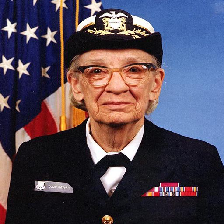

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper) / 255.0
print(grace_hopper.shape)

(224, 224, 3)


In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
print(predicted_class)

653


### Decode the predictions

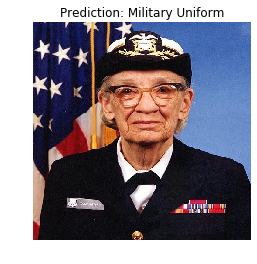

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_net_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = image_net_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

### Dataset

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [11]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} shape: {}".format(i + 1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


In [0]:
def image_formatter(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples // 4).map(image_formatter).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(image_formatter).batch(BATCH_SIZE).prefetch(1)

### Run the classifier on a batch of images

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = image_net_labels[np.argmax(result_batch, axis=-1)]
print(predicted_class_names)

['Labrador retriever' 'Egyptian cat' 'German shepherd' 'tiger cat'
 'dalmatian' 'West Highland white terrier' 'Persian cat' 'German shepherd'
 'miniature pinscher' 'basset' 'Staffordshire bullterrier' 'lynx' 'tabby'
 'chow' 'Egyptian cat' 'papillon' 'basenji' 'Shih-Tzu' 'skunk' 'Lhasa'
 'tabby' 'Tibetan mastiff' 'English springer' 'Egyptian cat'
 'Rhodesian ridgeback' 'dalmatian' 'cocker spaniel'
 'American Staffordshire terrier' 'boxer' 'chainlink fence' 'tabby'
 'Shih-Tzu']


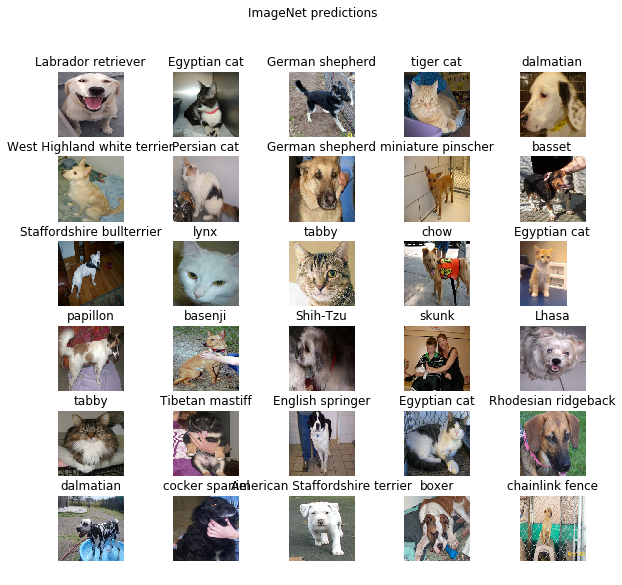

In [14]:
plt.figure(figsize=(10, 9))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[i])
    plt.title(predicted_class_names[i])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Part 3: Do simple transfer learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

### Attach a classification head

In [17]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 57s 98ms/step - loss: 0.2243 - acc: 0.9447 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 49s 84ms/step - loss: 0.1826 - acc: 0.9616 - val_loss: 0.1740 - val_acc: 0.9625
Epoch 3/6
582/582 [==============================] - 47s 81ms/step - loss: 0.1736 - acc: 0.9651 - val_loss: 0.1741 - val_acc: 0.9627
Epoch 4/6
582/582 [==============================] - 46s 80ms/step - loss: 0.1681 - acc: 0.9670 - val_loss: 0.1752 - val_acc: 0.9616
Epoch 5/6
582/582 [==============================] - 46s 79ms/step - loss: 0.1642 - acc: 0.9689 - val_loss: 0.1765 - val_acc: 0.9619
Epoch 6/6
582/582 [==============================] - 46s 79ms/step - loss: 0.1611 - acc: 0.9708 - val_loss: 0.1779 - val_acc: 0.9629


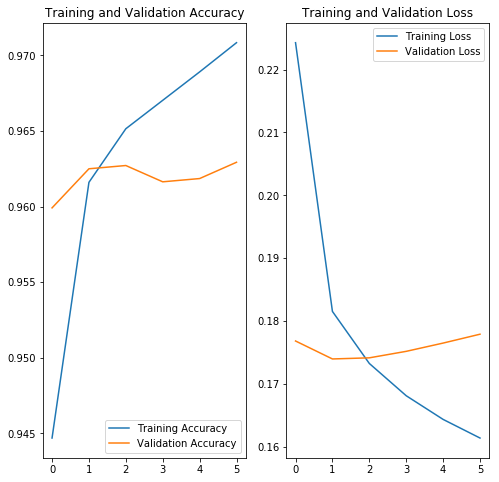

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Check the predictions

In [20]:
class_names = np.array(info.features['label'].names)
print(class_names)

['cat' 'dog']


In [21]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['dog' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat'
 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat'
 'dog' 'dog' 'dog' 'dog' 'dog' 'dog' 'dog' 'dog']


In [22]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1]
Predicted labels:  [1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1]


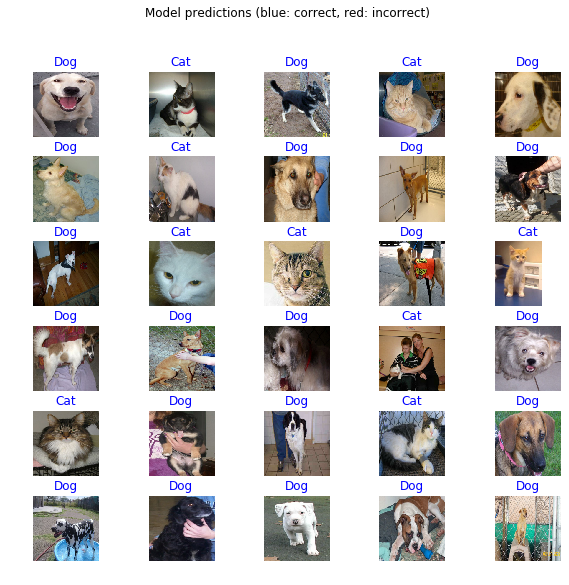

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")